In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Linear SVM classification of sentiment in tweets about airlines

Our primary goal is to classify tweets using sentiment analysis. Here, we are using Support Vector Machine (SVM) algorithm.

## Performing EDA on the dataset

  [1]: http://pandas.pydata.org/

In [2]:
import pandas as pd
tweets = pd.read_csv("Tweets.csv")
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

We'll limit the analysis to the information provided in the tweet in the form text only. Hence, the "text" column of of primary focus. 

Analyzing the corpus using head().

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Here, we aim to check the sentiments found.

In [4]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


On observation we realized that our dataset is significantly biased towards negative tweets. To solve this problem, we will identify the negative tweets and hereafter, treat neutral and positive as one class. Even though not recommended but if we predict a tweet to be negative, we'd still be right 62.7% of times.

The above isn't recommended as it would be a heavily biased classifier but definitely a strength to appreaciate.

# Characteristics of different types of sentiments:

To decide an optimum classification method, understanding the corpus is fundamental.

Here, we will use Python's NLTK library to tokenize and lemmatize text. We shall also convert all upper case to lower case characters. For sentiment analysis, context matters more than just words. Thus, we'll use bi-grams over individual tokens.

To simply perform the operations later, we'll store the processed data in the same python dataframe, i.e., "tweets" by extending the pandas dataframe.

### Preprocessing
Note that we remove the first two tokens as they always contain "@ airline_name". We begin by defining our normalization function.


  [1]: http://www.nltk.org/

In [5]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [6]:
normalizer("Here is text about an airline I like.")

['text', 'airline', 'like']

In [7]:
# Setting this so we can see the full content of cells

pd.set_option('display.max_colwidth', -1)
tweets['normalized_tweet'] = tweets.text.apply(normalizer)
tweets[['text','normalized_tweet']].head()

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [8]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,[dhepburn said]
1,"[added commercial, commercial experience, experience tacky, added commercial experience, commercial experience tacky]"
2,"[today must, must mean, mean need, need take, take another, another trip, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face amp, face amp little, amp little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


And now some counting.

In [9]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [10]:
tweets[(tweets.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(20)

[('http co', 449),
 ('customer service', 438),
 ('cancelled flightled', 425),
 ('late flight', 215),
 ('cancelled flighted', 196),
 ('flight cancelled', 185),
 ('late flightr', 144),
 ('cancelled flight', 131),
 ('hold hour', 128),
 ('flightled flight', 123),
 ('flight cancelled flightled', 117),
 ('flight delayed', 115),
 ('cancelled flightled flight', 107),
 ('call back', 106),
 ('booking problem', 98),
 ('gate agent', 83),
 ('flight flight', 74),
 ('hour late', 69),
 ('delayed flight', 69),
 ('flight attendant', 60)]

We can already tell there's a pattern here. Sentences like "cancelled flight", "late flight", "booking problems",  "delayed flight" stand out clearly. Lets check the positive tweets.

In [11]:
tweets[(tweets.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(20)

[('http co', 233),
 ('customer service', 91),
 ('flight attendant', 25),
 ('quick response', 19),
 ('great flight', 17),
 ('best airline', 16),
 ('great job', 16),
 ('great service', 16),
 ('gate agent', 16),
 ('booking problem', 15),
 ('thanks help', 15),
 ('thank much', 15),
 ('good work', 14),
 ('fleet fleek', 14),
 ('fleek http', 14),
 ('fleet fleek http', 14),
 ('fleek http co', 14),
 ('guy rock', 13),
 ('looking forward', 13),
 ('great customer', 12)]

We have some good looking patterns here. However, we can conclude that 3-grams clear patterns are rare. "great customer service" occurs 12 times in 2362 positive responses, which really doesn't say much in general. 

Satisfied that our data looks possible to work with begin to construct our first classifier.

# Linear SVM classifier
We will build a simple, linear Support-Vector-Machine (SVM) classifier. The classifier will take into account each unique word present in the sentence, as well as all consecutive words. To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

To create these vectors we use the CountVectorizer from [sklearn][1]. 


  [1]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Preparing the data

In [12]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [13]:
vectorized_data = count_vectorizer.fit_transform(tweets.text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [14]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.airline_sentiment.apply(sentiment2target)

To check performance of our classifier we want to split our data in to train and test.

In [15]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

## Fitting the classifier

We're now ready to fit the classifier to our data. We'll spend more time on hyper parameter tuning later, so for now we just pick some reasonable guesses. Note here that we use the OneVsRestClassifier. This allows us to get the probability distribution over all three classes. Behind the scenes we actually create three classifiers. Each of these classifiers determines the probability that the datapoint belongs to it's corresponding class, or any of the other classes. Hence the name OneVsRest.

In [16]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)
clf_prediction = clf.predict(data_test)

## Evaluation of results

In [17]:
print("Mean accuracy: ", clf.score(data_test, targets_test))

from sklearn.metrics import f1_score
f1_neu = f1_score(targets_test, clf_prediction, average=None)[0]
f1_neg = f1_score(targets_test, clf_prediction, average=None)[1]
f1_pos = f1_score(targets_test, clf_prediction, average=None)[2]
print("F1 score for neutral tweets: ",f1_neu)
print("F1 score for negative tweets: ",f1_neg)
print("F1 score for positive tweets: ",f1_pos)

Mean accuracy:  0.7851775956284153
F1 score for neutral tweets:  0.8649013780059444
F1 score for negative tweets:  0.6097178683385581
F1 score for positive tweets:  0.7042093287827076


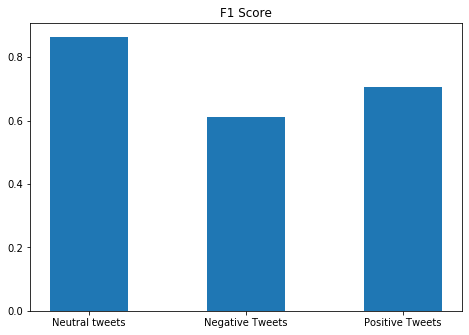

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ['Neutral tweets','Negative Tweets', 'Positive Tweets']
f1_scores = [f1_neu,f1_neg,f1_pos]
ax.bar(names,f1_scores, width = 0.5)
plt.title("F1 Score")
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

print("Confusion Matrix: \n", confusion_matrix(targets_test, clf_prediction))
#plot_confusion_matrix(clf, data_test, targets_test)

Confusion Matrix: 
 [[3201  376  102]
 [ 362  778  112]
 [ 160  146  619]]


It's most likely possible to achieve a higher score with more tuning, or a more advanced approach. Lets check on how it does on a couple of sentences.

In [23]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.21241729, 0.05759789, 0.72998482],
       [0.14553142, 0.06972021, 0.78474837],
       [0.94363099, 0.0392759 , 0.01709311],
       [0.89111251, 0.07204803, 0.03683947],
       [0.97409499, 0.0168776 , 0.00902741],
       [0.46882642, 0.50065528, 0.03051829],
       [0.26938323, 0.51920947, 0.2114073 ]])

So while results aren't very impressive overall, we can see that it's doing a good job on these obvious sentences. 

## What is hard for the classifier?

It's interesting to know which sentences are hard. To find out, lets apply the classifier to all our test sentences and sort by the marginal probability.

Here are some of the hardest sentences.

In [24]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [25]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[0:10]))

['@JetBlue - Definitely no note from whoever stole from me.',
 '@USAirways thanks. We did see an agent. Unhelpful. Some got vouchers others did not for unexplained reasons.',
 '@AmericanAir anything you can do?',
 '@AmericanAir Trying desperately to get my boyfriend booked on the same US Airways flight as myself for the same price. Can you help?',
 '@AmericanAir Trying desperately to get my boyfriend booked on the same US Airways flight as myself for the same price. Can you help?',
 "@JetBlue Crisis averted! Flight #69 from BOS to FLL is boarding. Let's hope the new pilots aren't Clarence Oveur and Roger Murdock. :-)",
 '@united that would help! or how about integrate it into the App so I can just "activate" it and surf...',
 '@SouthwestAir briughy me to @ComClassic, #AIF2015 &amp; so much more with the #agcommunity',
 '@AmericanAir I picked the nonstop flight bc I had things to get to. Should’ve taken diff route or airline I suppose!',
 '@SouthwestAir could care more about their custo

and their probability distributions?

In [26]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([0.47027673, 0.05944654, 0.47027673]),
 array([0.49537912, 0.00942167, 0.49519922]),
 array([0.48065885, 0.48025239, 0.03908877]),
 array([0.49486681, 0.49532926, 0.00980393]),
 array([0.49486681, 0.49532926, 0.00980393]),
 array([0.3522473 , 0.29599282, 0.35175988]),
 array([0.48296393, 0.48363794, 0.03339813]),
 array([0.33454651, 0.33016782, 0.33528566]),
 array([0.45238014, 0.45371747, 0.09390239]),
 array([0.47700717, 0.47853604, 0.0444568 ])]

How about the easiest sentences?

In [27]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[-10:]))

['@united here we go again. 2 of 3 segments SFO--New York RT were delayed OVER 2 hrs each! Why do you suck so BAD!?!Maybe another line of bus?',
 '@united is the worst airline. Lost my luggage delayed my flights and has been very unaccomidating',
 '@USAirways Been stuck for 40+ minutes due to lavatory issues. No beverages. No snacks. No customer service. Flt 645 to PHO... #fail #refund',
 '@AmericanAir Worst airline ever. We have been stranded for 24 hours because of your 7 hour delay with flight 104 last night.',
 "@USAirways seriously???  did you not see that I've spent 2 days - for multiple hours on hold just to have to hang up after the hours?",
 '@AmericanAir AA 1657 was also over an hour Late Flight to depart Ohare and now we have no luggage. Not happy standing in a long line at baggage svc',
 '@USAirways waited for 3 hours NO LUGGAGE line too long left airport when flight Cancelled Flighted WHERE does luggage GO? On hold for 1 hour so far',
 '@USAirways Customer service is dead.

and their probability distributions?

In [28]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([9.97340568e-01, 1.66633222e-03, 9.93099410e-04]),
 array([9.98023080e-01, 1.41472659e-03, 5.62193495e-04]),
 array([9.97914506e-01, 1.29035071e-03, 7.95143132e-04]),
 array([9.98730437e-01, 1.07962584e-03, 1.89937252e-04]),
 array([9.98808446e-01, 1.12622917e-03, 6.53244043e-05]),
 array([9.98741194e-01, 6.95198257e-04, 5.63607779e-04]),
 array([9.99027836e-01, 8.86524852e-04, 8.56391705e-05]),
 array([9.99060657e-01, 5.72924138e-04, 3.66418503e-04]),
 array([9.99200156e-01, 1.96769654e-04, 6.03074167e-04]),
 array([9.99470505e-01, 3.40640605e-04, 1.88854113e-04])]

Looks like all of the easiest sentences are negative. What is the distribution of certainty across all sentences?

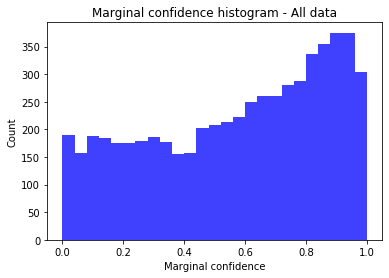

In [29]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

Lets break it down by positive and negative sentiment to see if one is harder than the other.

### Positive data

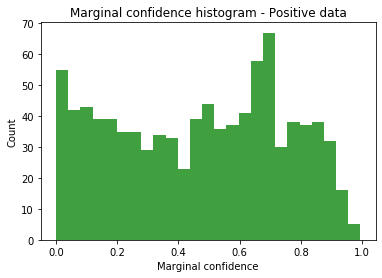

In [30]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### Neutral data

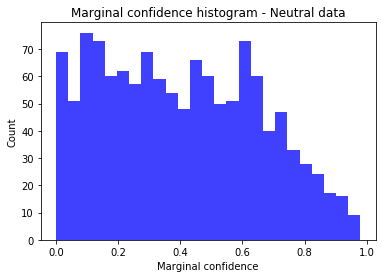

In [31]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### Negative data

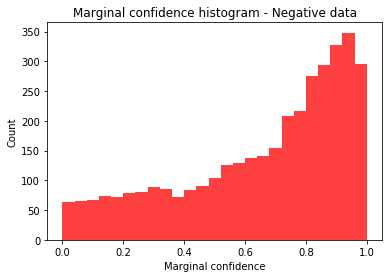

In [32]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

Clearly the positive data is much harder for the classifier. This makes sense since there's a lot less of it. An important challenge in building a better classifier will then be how to handle positive data.

A more advanced classifier is described here.